In [13]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
import matplotlib.pyplot as plt
from scipy import stats

from core.dataset import MachoDataset
from core.trainer import PredictionTrainer, ClassificationTrainer
from core.model import ClassificationModel

### Data setup

In [14]:
data_root = '/home/mrizhko/AML/AstroML/data/macho/'
weights_path = '/home/mrizhko/AML/AstroML/weights/model.ckpt'
window_length = 200
prediction_length = 50

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [35]:
train_dataset = MachoDataset(data_root, prediction_length, window_length=window_length, mode='train', use_errors=False)
val_dataset = MachoDataset(data_root, prediction_length, window_length=window_length, mode='val', use_errors=False)
test_dataset = MachoDataset(data_root, prediction_length, window_length=window_length, mode='test', use_errors=False)

In [36]:
past_times, future_times, past_values, future_values, past_mask, future_mask, aux, labels = train_dataset[0]
past_times.shape, future_times.shape, past_values.shape, future_values.shape, past_mask.shape, future_mask.shape, aux.shape, labels.shape

(torch.Size([150, 1]),
 torch.Size([50, 1]),
 torch.Size([150]),
 torch.Size([50]),
 torch.Size([150]),
 torch.Size([50]),
 torch.Size([3]),
 torch.Size([]))

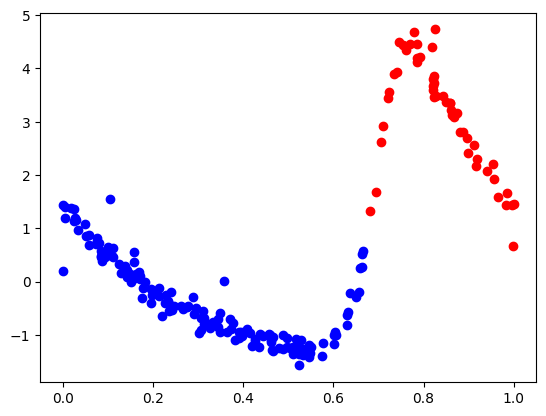

In [37]:
if train_dataset.use_errors:
    plt.errorbar(past_times, past_values[:, 0], past_values[:,1], fmt='o')
    plt.errorbar(future_times, future_values[:, 0], future_values[:,1], fmt='o', c='r')
else:
    plt.scatter(past_times, past_values, c='b')
    plt.scatter(future_times, future_values, c='r')  

In [38]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### Train prediction model

In [39]:
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=window_length - prediction_length - 7,  # 7 is max(lags) for default lags
    num_time_features=1,
    num_static_real_features=3,
    encoder_layers=2,
    decoder_layers=2,
    d_model=64,
    distribution_output='normal',
    scaling=None
)

In [40]:
model = TimeSeriesTransformerForPrediction(config)
model = model.to(device)

In [41]:
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

In [42]:
prediction_trainer = PredictionTrainer(model=model, optimizer=optimizer, device=device)

In [43]:
prediction_trainer.train(train_dataloader, val_dataloader, epochs=40)

Epoch 0: Train Loss 8.2663 Val Loss 3.4631
Epoch 1: Train Loss 5.2988 Val Loss 3.1096
Epoch 2: Train Loss 4.5599 Val Loss 2.9725
Epoch 3: Train Loss 4.1971 Val Loss 2.9128
Epoch 4: Train Loss 3.6612 Val Loss 2.8145
Epoch 5: Train Loss 3.4778 Val Loss 2.7578
Epoch 6: Train Loss 3.3027 Val Loss 2.733
Epoch 7: Train Loss 3.2636 Val Loss 2.6976
Epoch 8: Train Loss 3.0099 Val Loss 2.5106
Epoch 9: Train Loss 2.8213 Val Loss 2.3946
Epoch 10: Train Loss 2.7306 Val Loss 2.3797
Epoch 11: Train Loss 2.6541 Val Loss 2.3806
Epoch 12: Train Loss 2.5859 Val Loss 2.2046
Epoch 13: Train Loss 2.4114 Val Loss 2.1852
Epoch 14: Train Loss 2.4611 Val Loss 2.3784
Epoch 15: Train Loss 2.3784 Val Loss 2.0877
Epoch 16: Train Loss 2.4487 Val Loss 2.3039
Epoch 17: Train Loss 2.3765 Val Loss 2.1365
Epoch 18: Train Loss 2.3812 Val Loss 2.0752
Epoch 19: Train Loss 2.2993 Val Loss 2.367
Epoch 20: Train Loss 2.3609 Val Loss 2.0139
Epoch 21: Train Loss 2.5462 Val Loss 2.082
Epoch 22: Train Loss 2.2243 Val Loss 2.0448
E

In [44]:
model.save_pretrained(weights_path)

### Evaluate the pretrained model

In [45]:
model = TimeSeriesTransformerForPrediction.from_pretrained(weights_path)
model = model.to(device)

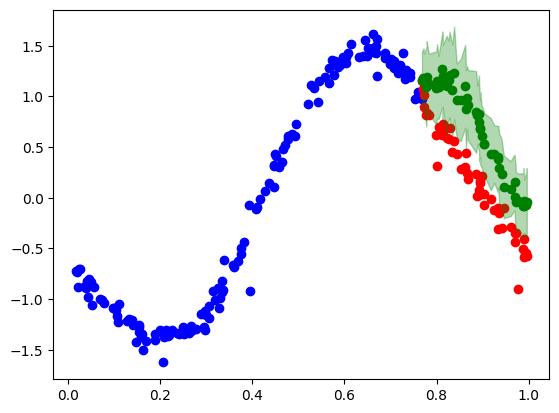

In [46]:
model.eval()
i = 1
past_times, future_times, past_values, future_values, past_mask, future_mask, aux, labels = train_dataset[i:i+1]

with torch.no_grad():
    outputs = model.generate(
        past_time_features=past_times.to(device),
        past_values=past_values.to(device),
        future_time_features=future_times.to(device),
        past_observed_mask=past_mask.to(device),
        static_real_features=aux.to(device),
    )
    
    if train_dataset.use_errors:
        plt.errorbar(past_times[0,:,0], past_values[:,0], past_values[:,1], fmt="o")
        plt.errorbar(future_times, future_values[:,0], future_values[:,1], fmt="o", c="r")
    else:
        plt.scatter(past_times[0,:,0], past_values[0,:], c="b")
        plt.scatter(future_times[0,:,0], future_values[0,:], c="r")  
        med = outputs.sequences[0,:,:].median(dim=0).values.cpu()
        mad = stats.median_abs_deviation(outputs.sequences[:,:,:].cpu(), axis=1, nan_policy="omit")
        plt.scatter(future_times[0,:,0].cpu(), med.cpu(), c="g")
    
        plt.fill_between(
            future_times[0,:,0],
            (med - mad)[0,:], 
            (med + mad)[0,:], 
            alpha=0.3, 
            interpolate=True,
            label="+/- 1-std",
            color="g"
        )

In [7]:
prediction_trainer = PredictionTrainer(model=model, optimizer=None, device=device)

In [8]:
val_dataloader = DataLoader(val_dataset, batch_size=124, shuffle=False)

In [9]:
prediction_trainer.evaluate(val_dataloader, val_dataset)

100%|█████████████████████████████████████| 16028/16028 [06:27<00:00, 41.40it/s]

MASE: 0.8835637644970156 sMAPE: 0.8496397286677474


### Classification training

In [47]:
cl_model = ClassificationModel(pretrained_model_path=weights_path, device=device)
cl_optimizer = AdamW(cl_model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)
cl_criterion = nn.CrossEntropyLoss()

In [48]:
cl_trainer = ClassificationTrainer(model=cl_model, optimizer=cl_optimizer, criterion=cl_criterion, device=device)

In [49]:
balanced_data_root = '/home/mrizhko/AML/AstroML/data/macho-balanced/'

train_dataset = MachoDataset(balanced_data_root, prediction_length, window_length=window_length, 
                             mode='train', use_errors=False)
val_dataset = MachoDataset(balanced_data_root, prediction_length, window_length=window_length, 
                           mode='val', use_errors=False)
test_dataset = MachoDataset(balanced_data_root, prediction_length, window_length=window_length, 
                            mode='test', use_errors=False)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [50]:
cl_trainer.train(train_dataloader, val_dataloader, epochs=100)

Epoch 0: Train Loss 1.9851 	 Val Loss 1.7566 	                     Train Acc 0.2081 	 Val Acc 0.3222
Epoch 1: Train Loss 1.6972 	 Val Loss 1.5583 	                     Train Acc 0.3067 	 Val Acc 0.3337
Epoch 2: Train Loss 1.5237 	 Val Loss 1.459 	                     Train Acc 0.3536 	 Val Acc 0.3968
Epoch 3: Train Loss 1.4228 	 Val Loss 1.3737 	                     Train Acc 0.4004 	 Val Acc 0.4314
Epoch 4: Train Loss 1.3453 	 Val Loss 1.2927 	                     Train Acc 0.4373 	 Val Acc 0.4933
Epoch 5: Train Loss 1.324 	 Val Loss 1.2497 	                     Train Acc 0.4391 	 Val Acc 0.52
Epoch 6: Train Loss 1.2681 	 Val Loss 1.2223 	                     Train Acc 0.4663 	 Val Acc 0.54
Epoch 7: Train Loss 1.2307 	 Val Loss 1.1859 	                     Train Acc 0.4921 	 Val Acc 0.5449
Epoch 8: Train Loss 1.1597 	 Val Loss 1.1425 	                     Train Acc 0.5351 	 Val Acc 0.5746
Epoch 9: Train Loss 1.1675 	 Val Loss 1.0763 	                     Train Acc 0.5323 	 Val Acc 0.6

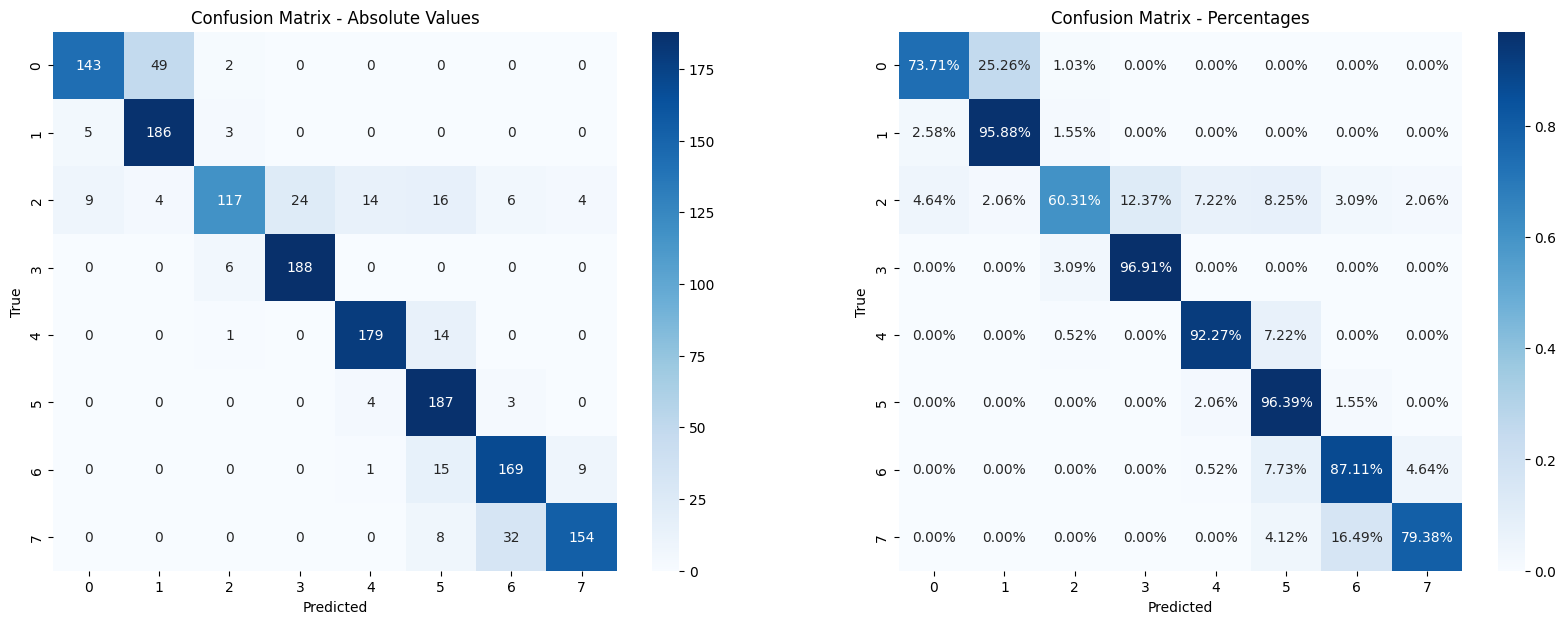

In [51]:
cl_trainer.evaluate(test_dataloader)